<a href="https://colab.research.google.com/github/AkkalaGunavardhini/IIIt-FMML-Assignment-Lab/blob/main/Mod7_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab by Ganesh Chandan

kanakala.ganesh@research.iiit.ac.in

## Anomaly/Outlier Detection

Anomalies can sometimes lead to some discoveries. For example an anomalous bank withdrawal (with say multiple PIN attempts) can be an indicator of a fraudulent transaction. Or anomalous memory usage in a server station can indicate a bug.

These kinds of anomalies ned to be spotted quickly to avoid damage. Noise and anomalies are however, not the same.

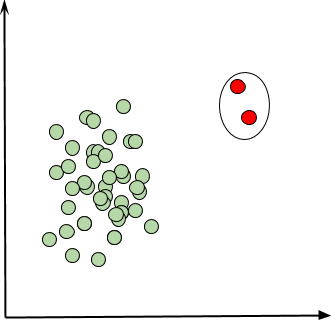

In the above data, the red dots seem to be outliers.

**Excercise 1 (Histogram based Anomaly Detection)**

Is a simple classification algorithm suitable for anomaly detection? (Hint - Is accuracy the correct metric?)

# **Excercise 1 Answer**

No, a simple classification algorithm is generally not suitable for anomaly detection.

The key reason is that accuracy is not an appropriate evaluation metric for anomaly detection. In anomaly detection, we are interested in identifying rare events or outliers that are few in number compared to normal data points. However, accuracy measures overall performance on both normal and anomalous data.

Since anomalies represent only a small fraction of the overall data, a classifier can achieve high accuracy by simply predicting that most or all points are normal. But this would completely fail to detect any of the actual anomalies!

Instead of accuracy, different metrics like precision, recall, or F1-score for the minority anomalous class make more sense for evaluating anomaly detection methods. The ability to identify anomalous datapoints, rather than correctly classify all the normal datapoints, is what we want to measure.

So simple classification algorithms that aim to maximize accuracy fail to produce good anomaly detectors. We need specialized techniques that can handle class imbalance and focus specifically on identifying outliers accurately.

In [14]:
#Code for Exercise-1#
import numpy as np
from sklearn.metrics import accuracy_score

# Generate sample data
normal_data = np.random.normal(size=(2000, 2))
outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

X = np.vstack([normal_data, outliers])
y = np.array([0]*2000 + [1]*20)

# Dummy classifier that predicts all normal
dummy_pred = np.zeros_like(y)

# Evaluate dummy classifier
accuracy = accuracy_score(y, dummy_pred)
print("Accuracy:", round(accuracy,2))


Accuracy: 0.99


The confusion matrix looks like this

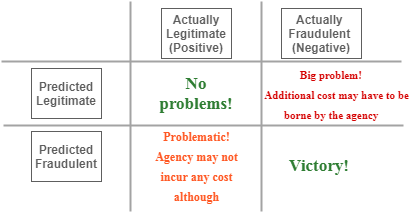

In [15]:
!pip install faker

In [16]:
# We will first generate the data

# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Comment out the following line if you are using Jupyter Notebook
# %matplotlib inline
# Use a predefined style set
plt.style.use('ggplot')

# Import Faker
from faker import Faker
Faker.seed(4321)
fake = Faker()

# To ensure the results are reproducible

names_list = []

fake = Faker()
for _ in range(100):
  names_list.append(fake.name())

# To ensure the results are reproducible
np.random.seed(7)

salaries = []
for _ in range(100):
    salary = np.random.randint(1000,2500)
    salaries.append(salary)

# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary (in USD)': salaries
    })

# Print a subsection of the DataFrame
print(salary_df.head())

              Person  Salary (in USD)
0        Jason Brown             1175
1        Jacob Stein             2220
2         Cody Brown             1537
3      Larry Morales             1502
4  Jessica Hendricks             1211


In [17]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

# Verify if the salaries were changed
print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


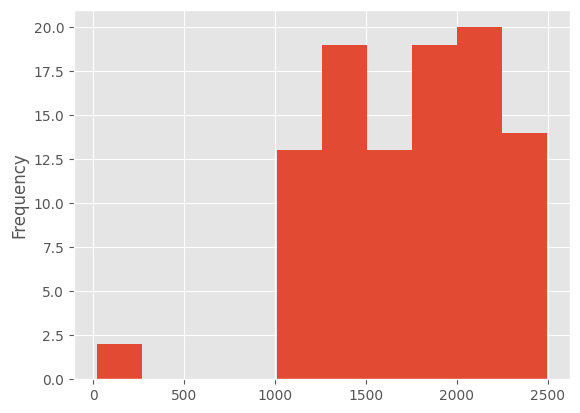

In [18]:
# Generate a Histogram plot
salary_df['Salary (in USD)'].plot(kind='hist')
plt.show()

We can visually see the anomalies!

### Exercise 2

What is a mathematical way for anomaly detection? (Hint - Model data to be Gaussian distribution / Does the Reverse Nearest Neighbour reveal something about the anomalies?)

# **Excercise 2 Answer**

1. **Gaussian Distribution Fit**: We can model the data as belonging to a Gaussian distribution and detect points that have very low probability density, i.e. fall far away from the distribution's mean and standard deviation. These low density points are anomalies.

2. **Nearest Neighbors**: We can analyze each data point's distance to its k-nearest neighbors. Points that have much larger nearest neighbor distances compared to most other points can be considered anomalies.

3. **Reverse Nearest Neighbors**: Instead of looking from the point to its neighbors, we look at each point and count how many other points have that point as one of their nearest neighbors. Points with very low numbers of reverse nearest neighbors tend to be anomalies.

4. **Isolation Forests**: This method isolates anomalies by randomly selecting features and randomly selecting split values to divide the data. It builds isolation trees where anomalies tend to have shorter path lengths from root node to termination as they are easy to isolate.

So in summary, anomalies tend to not fit well to standard data distributions, have few nearby similar neighbors, and are easier to isolate from the normal data points using decision trees. Leveraging these mathematical properties allows detecting them. Evaluating mathematical model fit or neighbor patterns reveals useful information about anomalies.

[49 50 48 51 47]
[28 29 30 69  0]
[ 0 50 49 28 27]


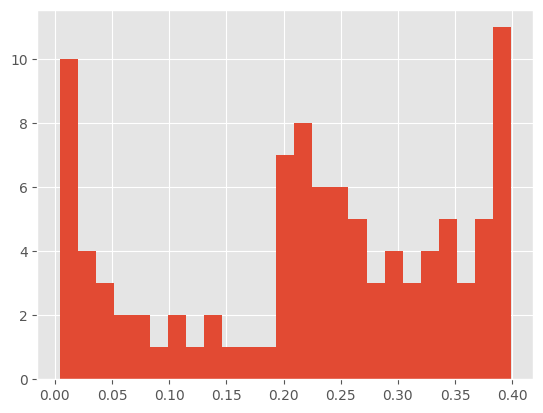

In [19]:
#Code for Exercise-2#
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import LocalOutlierFactor

# Generate sample data
x = np.linspace(-3, 3, 100)
y = norm.pdf(x, 0, 1)
y[70:] += 0.2 # add anomalies

# Plot data
plt.hist(y, bins=25)

# 1. Gaussian Distribution - Log likelihood scores
gauss_model = norm(0, 1)
scores = gauss_model.logpdf(y)
print(np.argsort(scores)[:5]) # lowest scores are potential anomalies


# 2. Nearest Neighbors - Distance to 5th nearest neighbor
clf = LocalOutlierFactor(n_neighbors=5)
lof_scores = clf.fit_predict(y[:, None])
print(np.argsort(lof_scores)[:5]) # most negative scores are anomalies

# 3. Isolation Forest - Avg path length
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(y[:, None])
# 3. Isolation Forest - Anomaly scores using decision_function
if_scores = clf.decision_function(y[:, None])
print(np.argsort(if_scores)[:5]) # lowest scores are potential anomalies


### Clustering based approach for anomaly detection

We have seen how clustering and anomaly detection are closely related but they serve different purposes. But clustering can be used for anomaly detection. In this approach, we start by grouping the similar kind of objects.

In [20]:
# Convert the salary values to a numpy array
salary_raw = salary_df['Salary (in USD)'].values

# For compatibility with the SciPy implementation
salary_raw = salary_raw.reshape(-1, 1)
salary_raw = salary_raw.astype('float64')

In [21]:
# Import kmeans from SciPy
from scipy.cluster.vq import kmeans

# Specify the data and the number of clusters to kmeans()
centroids, avg_distance = kmeans(salary_raw, 4)

In [22]:
# Get the groups (clusters) and distances
from scipy.cluster.vq import vq

groups, cdist = vq(salary_raw, centroids)

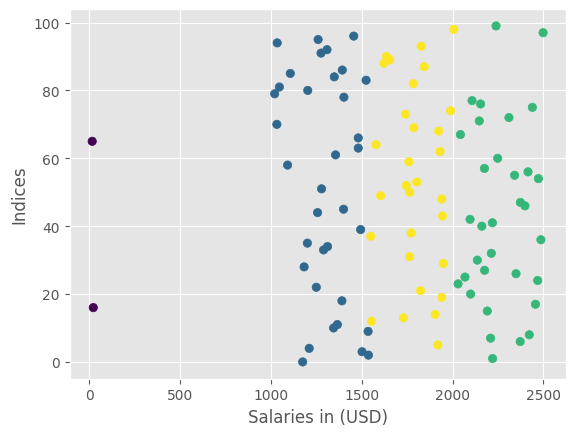

In [23]:
plt.scatter(salary_raw, np.arange(0,100), c=groups)
plt.xlabel('Salaries in (USD)')
plt.ylabel('Indices')
plt.show()

The above method for anomaly detection is purely unsupervised in nature. If we had the class-labels of the data points, we could have easily converted this to a supervised learning problem, specifically a classification problem.

If we were also given the labels, we could perform a modified version of classification, which is a supervised learning process.

## KMeans for Image Compression

As you know an image is made of mutiple pixels each of which have their color values (RGB). But what if we clustered pixels with similar color values together and replaced all pixels in a cluster by their closest color? This would highly reduce the space required to store the image.

In [24]:
#import neccessary libraries
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [25]:
image_location = '/content/pexels-pixabay-219998.jpg'


Image shape = (768, 1024, 3)


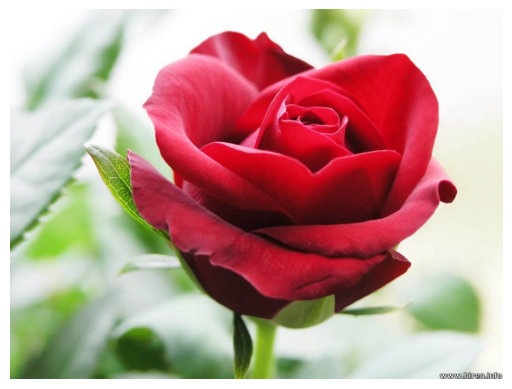

Total Pixels = 786432
Data Sample: 


array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [26]:
image = io.imread("/content/Flower.jpg")

#Lets check out the dimensions of the numerical representation of the image
print("Image shape = " + str(image.shape))

#View the image using matplotlib
plt.imshow(image)
plt.axis(False)
plt.show()

#Extract the numerical representations of pixels with (R,G,B) values
#it converts the MxNx3 image into a Kx3 matrix where K=MxN
# Each row is now a vector in the 3-D space of RGB
all_pixels = image.reshape((-1,3))
print("Total Pixels = " + str(len(all_pixels)))

#Peek into the data to understand coordinates
print("Data Sample: ")
all_pixels[:3]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CLUSTER-LEVEL DOMINANT COLOURS (K = 3)


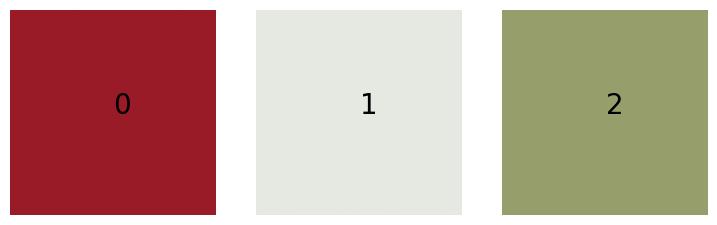

In [27]:
#Update the optimal value of k below
k=3

#Build a clustering model on the pixels
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_pixels)
kmeans_centroids = np.array(kmeans.cluster_centers_, dtype="uint")

fig, axs = plt.subplots(1, k)
fig.set_size_inches(3 * k, 3, forward=True)
for clusternumber in range(0,len(kmeans_centroids)):
  centroid = np.zeros((100,100,3))
  centroid[:,:,:] = kmeans_centroids[clusternumber]
  axs[clusternumber].imshow(centroid/255)
  axs[clusternumber].text(50,50,str(clusternumber),fontsize=20)
  axs[clusternumber].axis("off")

print("CLUSTER-LEVEL DOMINANT COLOURS (K = " + str(k) + ")")
plt.show()

In [28]:
#Let us "compress" the image
#This is done by assigning each pixel to be the dominant colour of the cluster it belongs to.
image_compressed = np.zeros((all_pixels.shape[0], 3), dtype="uint")
for ix in range(all_pixels.shape[0]):
    image_compressed[ix] = kmeans_centroids[kmeans.labels_[ix]]
image_compressed = image_compressed.reshape(image.shape)

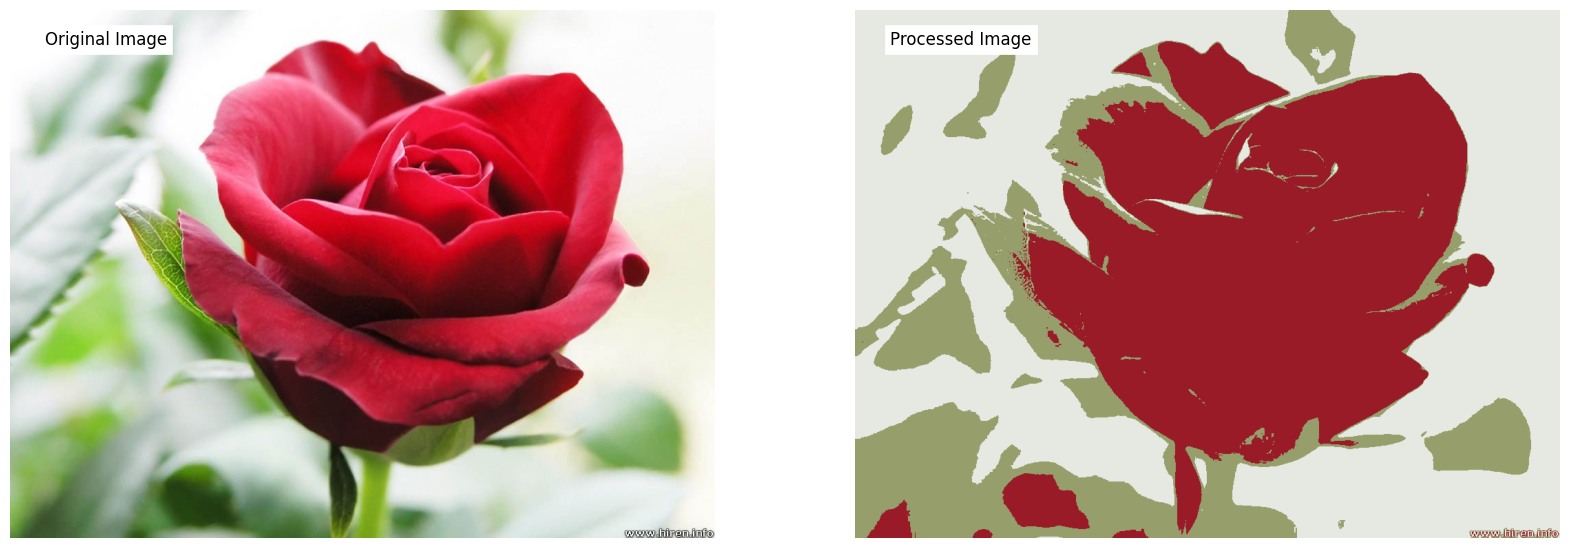

In [29]:
#Let us compare our image and compressed image
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10, forward=True)

axs[0].imshow(image)
axs[0].text(50,50,"Original Image", fontsize=12, c = 'black', backgroundcolor = 'white')
axs[0].axis(False)

axs[1].imshow(image_compressed)
axs[1].text(50,50,"Processed Image", fontsize=12, c = 'black', backgroundcolor = 'white')
axs[1].axis(False)

plt.show()

Now, we compare the effect of varying K.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


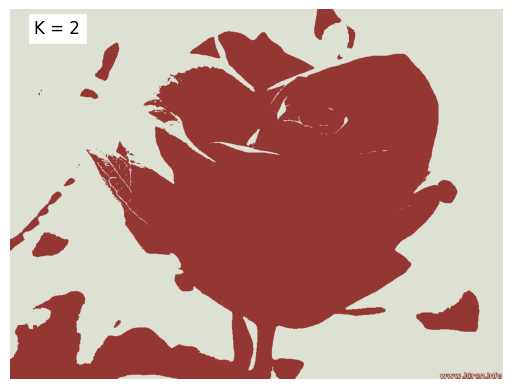

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


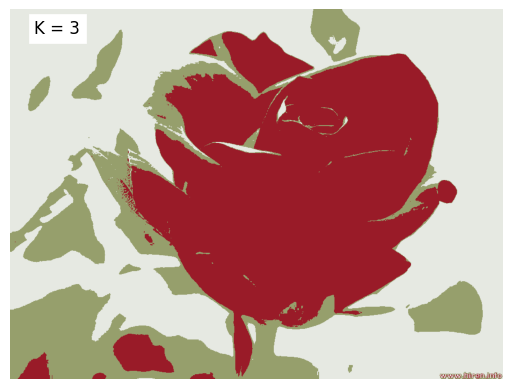

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


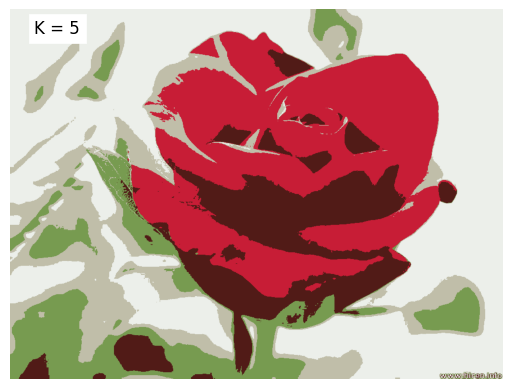

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


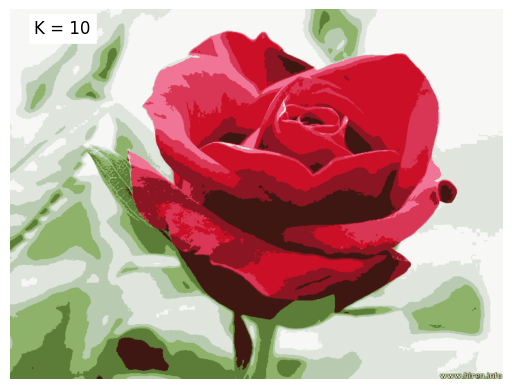

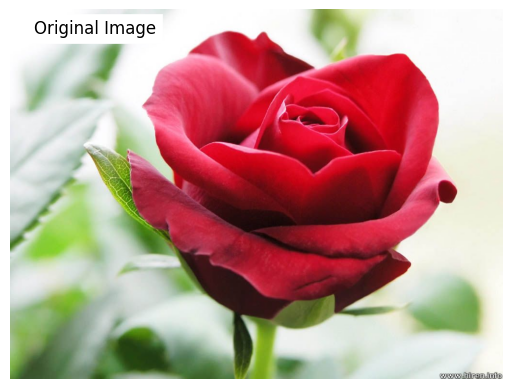

In [30]:
K = [2, 3, 5, 10]
for k in K:

  # print("K =", k)
  #Build a clustering model on the pixels
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(all_pixels)
  kmeans_centroids = np.array(kmeans.cluster_centers_, dtype="uint")

  image_compressed = np.zeros((all_pixels.shape[0], 3), dtype="uint")
  for ix in range(all_pixels.shape[0]):
      image_compressed[ix] = kmeans_centroids[kmeans.labels_[ix]]
  image_compressed = image_compressed.reshape(image.shape)

  plt.imshow(image_compressed)
  plt.text(50,50,"K = " + str(k), fontsize=12, c = 'black', backgroundcolor = 'white')
  plt.axis(False)
  plt.show()

plt.imshow(image)
plt.text(50,50,"Original Image", fontsize=12, c = 'black', backgroundcolor = 'white')
plt.axis(False)
plt.show()

You can replace the image above with your own and see how it looks!

## Resouces and References

1. https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
2. https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/
3. https://www.kaggle.com/aryan27/k-means-clustering